# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
from collections import Counter
from sklearn.preprocessing import PowerTransformer


from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import time

warnings.filterwarnings("ignore")

### Подгружаем данные

In [ ]:
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv

--2022-11-03 13:10:29--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329268 (5.1M) [text/plain]
Saving to: ‘PD-data-train.csv’

PD-data-train.csv   100%[===================>]   5.08M  --.-KB/s    in 0.09s   

2022-11-03 13:10:29 (54.5 MB/s) - ‘PD-data-train.csv’ saved [5329268/5329268]

--2022-11-03 13:10:29--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28259 (28

# EDA

In [2]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

In [3]:
desc_df

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)
5,ar_sale_profit,Profit from sales (at the end of the last year),Прибыль от реализации (на конец последнего года)
6,ar_balance_of_rvns_and_expns,Balance of income and expenses (at the end of ...,Баланс доходов и расходов (на конец последнего...
7,ar_profit_before_tax,Gross Profit (end of last year),Валовая прибыль (на конец последнего года)
8,ar_taxes,Current income tax (at the end of the last year),Текущий на налог на прибыль (на конец последне...
9,ar_other_profit_and_losses,Other income and expenses (at the end of the l...,Прочие доходы и расходы (на конец последнего г...


In [4]:
train_df.head(10)

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,27,[1-100],10000.0,2,0,0,0,0
5,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,5,5,[1-100],350000.0,1,0,0,0,0
6,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7,7,7,[1-100],35000.0,3,0,0,0,0
7,37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30,30,30,[1-100],10000.0,2,0,0,0,0
8,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26,26,26,[1-100],10000.0,1,0,0,0,0
9,40,125432000.0,122655000.0,122655000.0,0.0,0.0,2777000.0,-63000.0,2714000.0,579000.0,...,15,15,15,(100-500],10000.0,2,0,0,0,0


In [5]:
test_df.head(10)

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,...,135,3,3,3,[1-100],100000.0,1,0,0,0
1,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138,5,5,5,[1-100],100000.0,1,0,0,0
2,2813,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,...,138,20,20,20,[1-100],250000.0,2,0,0,0
3,4385,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,...,139,9,9,9,[1-100],10000.0,2,0,0,0
4,6479,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,...,139,3,3,3,(100-500],1700598.0,84,0,0,0
5,6726,14447000.0,13843000.0,13843000.0,0.0,0.0,604000.0,400000.0,1004000.0,0.0,...,92,14,14,14,> 500,558967.0,1,0,0,0
6,9178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,98,28,28,28,(100-500],10000.0,1,0,0,0
7,13143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43,28,28,28,[1-100],10000.0,1,0,0,0
8,13547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16,11,11,11,[1-100],10000.0,1,0,0,0
9,18483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33,2,2,2,[1-100],10000.0,1,0,0,0


In [6]:
train_df.shape

(32395, 37)

In [7]:

train_df.record_id.nunique()

32395

In [8]:
train_df.dtypes.value_counts()

float64    25
int64      11
object      1
dtype: int64

0    30304
1     2091
Name: default_12m, dtype: int64


<AxesSubplot:>

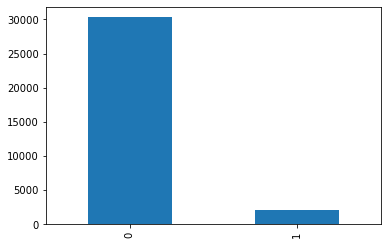

In [9]:
print(train_df.default_12m.value_counts())
train_df.default_12m.value_counts().plot.bar()

В задаче явно наблюдается дисбаланс классов  
Итоговое предсказание формируется в результате бинаризации вероятностной интерпретации результата модели (по стандарту порог равен 0.5). Однако этот порог можно подобрать.  
В итоге будем ориентироваться на ранжирующую способность модели (метрика: roc-auс), из которой можно будет оптимальным образом подобрать порог для разбиения на классы

In [10]:
train_df.select_dtypes('object').apply(pd.Series.value_counts, axis = 0)

,ul_staff_range
[1-100],29281
(100-500],2757
> 500,357


<AxesSubplot:xlabel='ul_staff_range', ylabel='count'>

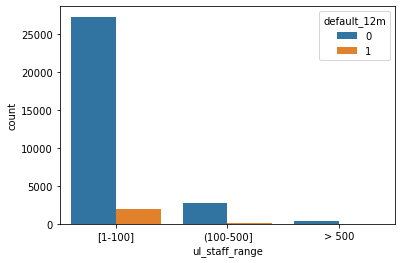

In [11]:
sns.countplot('ul_staff_range', data=train_df, hue='default_12m')

In [12]:
# В группе (1-100) выше процент дефолта
for bin_ in train_df.ul_staff_range.unique():
    perc = len(train_df[(train_df.ul_staff_range == bin_) & (train_df.default_12m == 1)]) / len(train_df[train_df.ul_staff_range == bin_]) * 100
    print('perc of def in {} : {} %'.format(bin_, round(perc, 2)))

perc of def in [1-100] : 6.89 %
perc of def in (100-500] : 2.47 %
perc of def in > 500 : 1.96 %


In [13]:
def miss_vals(df):
    mis_stat = df.isna().sum()
    perc_of_mis = round(mis_stat / len(df) * 100, 2)
    frame = pd.concat([mis_stat, perc_of_mis], axis=1)
    frame = frame.rename(columns={0: 'total', 1: 'perc_of_total'})
    frame = frame.sort_values(by=['perc_of_total'], ascending=False)[frame.perc_of_total > 0]
    print(f'num of mis cols: {frame.shape[0]}')
    return frame

In [14]:
#везде одинаковый процент пропусков в данных, близко к 50%
mis_cols = miss_vals(train_df)
mis_cols

num of mis cols: 24


,total,perc_of_total
ab_losses,15145,46.75
ab_mobile_current_assets,15145,46.75
ab_other_borrowings,15145,46.75
ab_accounts_payable,15145,46.75
ab_short_term_borrowing,15145,46.75
ab_long_term_liabilities,15145,46.75
ab_borrowed_capital,15145,46.75
ab_own_capital,15145,46.75
ar_revenue,15145,46.75
ab_cash_and_securities,15145,46.75


In [15]:
# посмотрим на распределения таргета отдельно для id с NaN и без
without_na = train_df.dropna(axis='index', how='any')
with_na = train_df.iloc[list(set(train_df.index) -  set(without_na.index))]

0    91.45
1     8.55
Name: default_12m, dtype: float64


<AxesSubplot:>

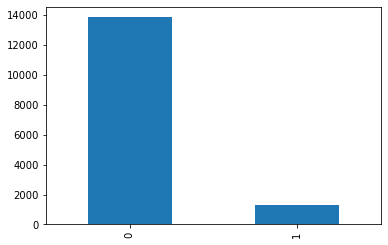

In [16]:
print(round(with_na.default_12m.value_counts() / len(with_na) * 100, 2))
with_na.default_12m.value_counts().plot.bar()

0    95.0
1     5.0
Name: default_12m, dtype: float64 2


<AxesSubplot:>

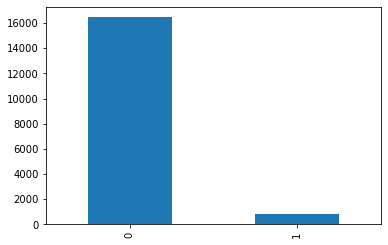

In [17]:
print(round(without_na.default_12m.value_counts() / len(without_na) * 100), 2)
without_na.default_12m.value_counts().plot.bar()

Процент компаний, ушедших в дефолт с NaN больше

In [18]:
# признаки с константым значением
full_cols = set(train_df.columns) - set(list(mis_cols.index) + ['default_12m', 'record_id'])
const = train_df[full_cols].nunique()[train_df[full_cols].nunique() == 1].index.tolist()
const

['ul_systematizing_flg']

In [19]:
# не информативный признак
train_df.ul_strategic_flg.value_counts()

0    32392
1        3
Name: ul_strategic_flg, dtype: int64

In [20]:
not_info = ['ul_strategic_flg']

In [21]:
#корреляция
train_df.corr()['default_12m'].sort_values(ascending=False)

default_12m                     1.000000
ar_balance_of_rvns_and_expns    0.005408
ul_strategic_flg               -0.002528
record_id                      -0.002880
ab_long_term_liabilities       -0.006409
ab_other_current_assets        -0.009262
ar_management_expenses         -0.009482
ab_other_borrowings            -0.011478
ar_other_profit_and_losses     -0.011694
ab_short_term_borrowing        -0.011695
ul_branch_cnt                  -0.014410
ab_cash_and_securities         -0.017529
ul_capital_sum                 -0.019452
ar_selling_expenses            -0.020460
ul_founders_cnt                -0.023244
ab_borrowed_capital            -0.025285
ab_accounts_payable            -0.026061
ab_immobilized_assets          -0.026570
ab_accounts_receivable         -0.028233
ar_net_profit                  -0.030548
ar_profit_before_tax           -0.033238
ar_sale_profit                 -0.034862
ab_inventory                   -0.041404
ab_mobile_current_assets       -0.042771
ar_taxes        

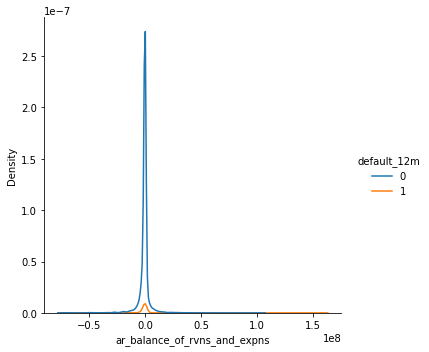

In [22]:
sns.displot(data=train_df, x=train_df.ar_balance_of_rvns_and_expns, kind='kde', hue ='default_12m')

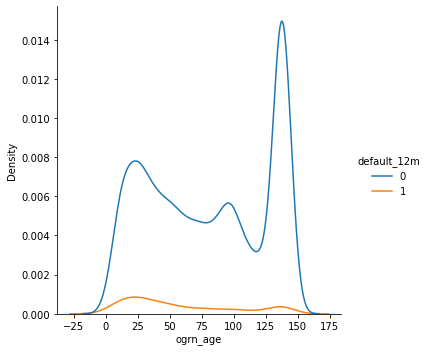

In [23]:
sns.displot(data=train_df, x=train_df.ogrn_age, kind='kde', hue ='default_12m')

In [24]:
cols_with_minus_val = []
cols_without_minus_val = []
for i in train_df.select_dtypes(exclude='object').drop(columns=['default_12m','record_id'] + const + not_info).columns:
    if (train_df[i] < 0).sum() > 0:
        cols_with_minus_val.append(i)
    else:
        cols_without_minus_val.append(i)

In [25]:
cols_with_minus_val

['ar_total_expenses',
 'ar_sale_cost',
 'ar_selling_expenses',
 'ar_management_expenses',
 'ar_sale_profit',
 'ar_balance_of_rvns_and_expns',
 'ar_profit_before_tax',
 'ar_taxes',
 'ar_other_profit_and_losses',
 'ar_net_profit',
 'ab_accounts_receivable',
 'ab_other_current_assets',
 'ab_losses',
 'ab_own_capital',
 'ab_long_term_liabilities',
 'ab_short_term_borrowing',
 'ab_other_borrowings']

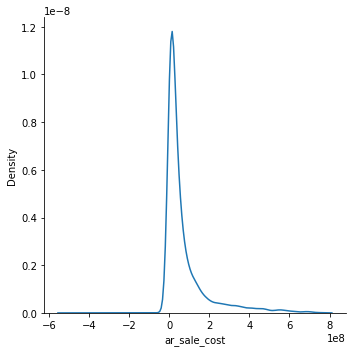

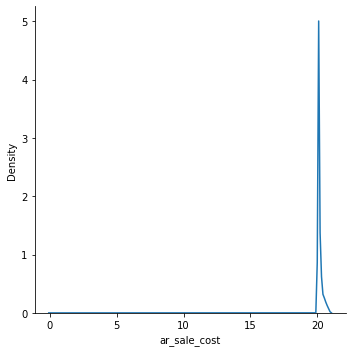

In [26]:
# свдиг на константу, чтобы не потерять отрицательные значения
sns.displot(train_df.ar_sale_cost, kind='kde')
sns.displot(np.log1p(train_df.ar_sale_cost - min(train_df.ar_sale_cost)), kind='kde')

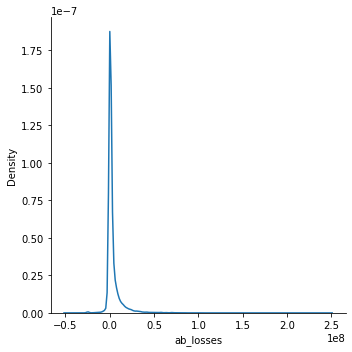

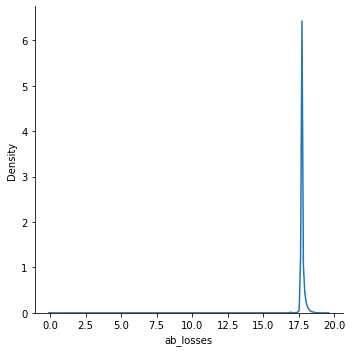

In [27]:
sns.displot(train_df.ab_losses, kind='kde')
sns.displot(np.log1p(train_df.ab_losses - min(train_df.ab_losses)), kind='kde')

In [28]:
cols_without_minus_val

['ar_revenue',
 'ab_immobilized_assets',
 'ab_mobile_current_assets',
 'ab_inventory',
 'ab_cash_and_securities',
 'ab_borrowed_capital',
 'ab_accounts_payable',
 'bus_age',
 'ogrn_age',
 'adr_actual_age',
 'head_actual_age',
 'cap_actual_age',
 'ul_capital_sum',
 'ul_founders_cnt',
 'ul_branch_cnt']

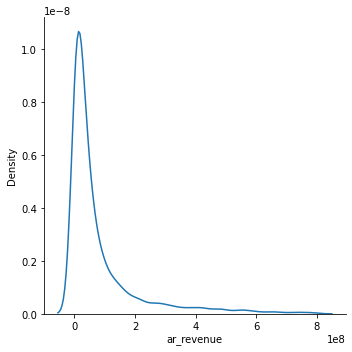

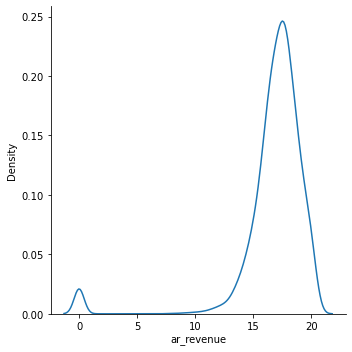

In [29]:
sns.displot(train_df.ar_revenue, kind='kde')
sns.displot(np.log1p(train_df.ar_revenue), kind='kde')

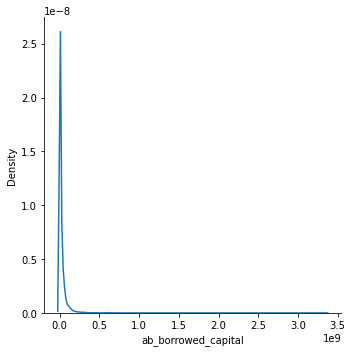

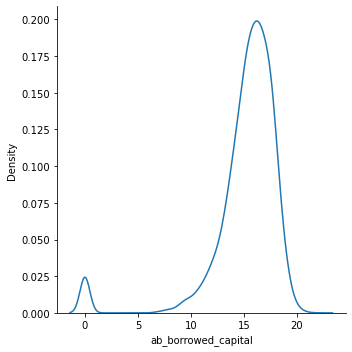

In [30]:
sns.displot(train_df.ab_borrowed_capital, kind='kde')
sns.displot(np.log1p(train_df.ab_borrowed_capital), kind='kde')

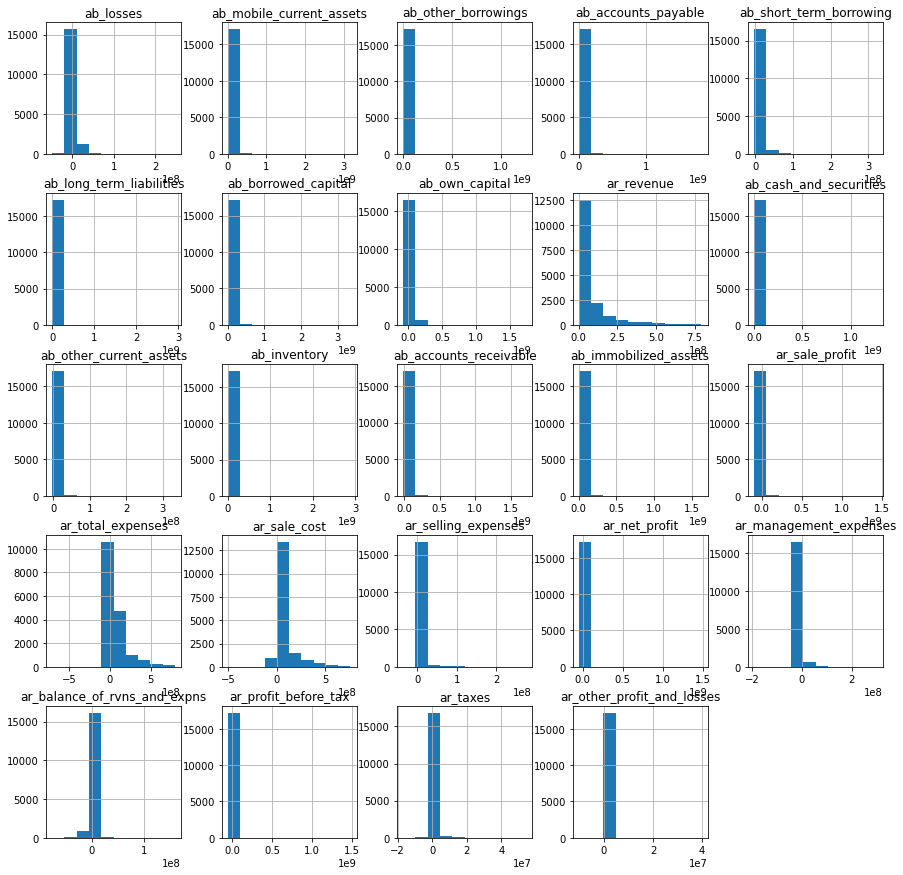

In [31]:
train_df[mis_cols.index].hist(figsize=(15, 15))
plt.show()

Распределения величин сильно похожи между собой. Есть лишь небольшие отличия в масштабах и сдвигах

In [32]:
# Находим выбросы
def detect_outliers(df,n,features):

    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col],75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers 

In [33]:
outliers = detect_outliers(train_df, 2, train_df.select_dtypes(exclude='object').drop(columns=['default_12m','record_id'] + const).columns.tolist())

In [34]:
len(outliers)

35

In [35]:
train_df = train_df.drop(outliers, axis=0)

In [36]:
# После заполнения пропусков медианным значением распределения изменяются не сильно
def fill_na(train_df, test_df, cols):
    for col in cols:
         train_df[col].fillna(train_df[col].median(), inplace=True)
         test_df[col].fillna(train_df[col].median(), inplace=True)

In [37]:
fill_na(train_df, test_df, mis_cols.index)

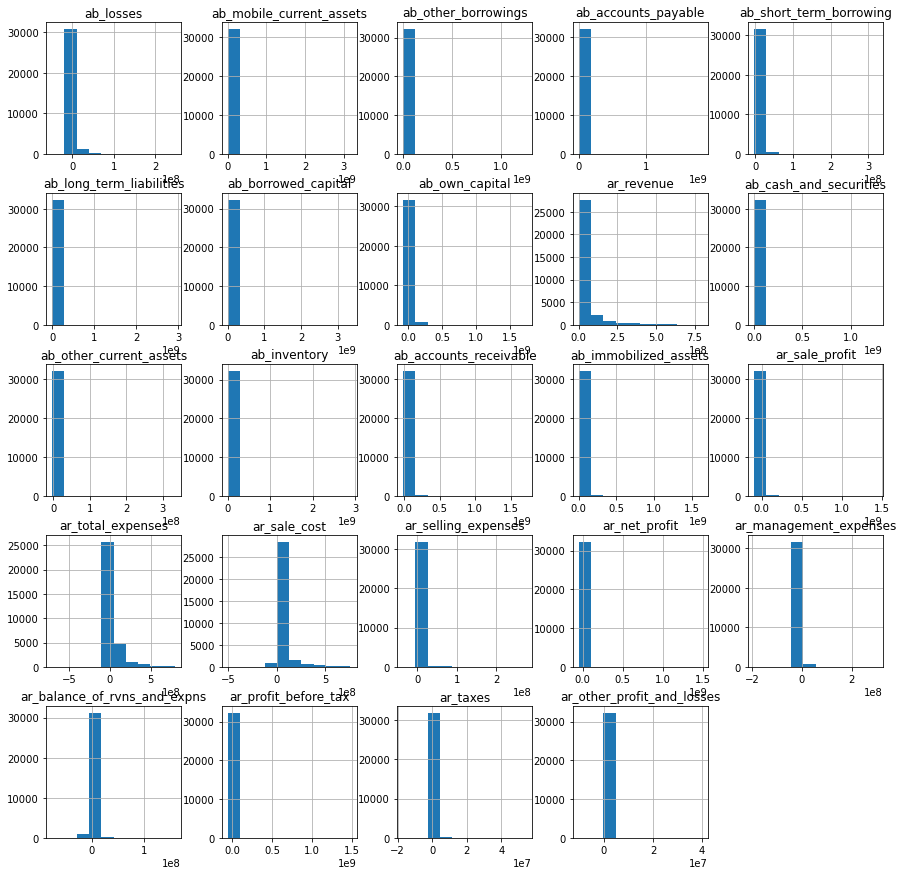

In [38]:
train_df[mis_cols.index].hist(figsize=(15, 15))
plt.show()

# Feauture extraction & engineering

In [39]:
feats_to_drop =  ['record_id'] + const + not_info

In [40]:
# Добавим некоторые фичи, исходя из их описания
def add_feats(df):
    df['sale/revenue'] = df['ar_sale_profit'] / (df['ar_revenue'] + 1e-10)
    df['cap/found'] = df['ul_capital_sum'] / df['ul_founders_cnt']
    df['inv/cap'] = df['ab_inventory'] / (df['ab_own_capital'] + 1e-10)
    df['taxes/profit'] = df['ar_taxes'] / (df['ar_sale_profit'] + 1e-10)
    return df

In [41]:
X_train = add_feats(train_df.drop(columns=['default_12m']))
y_train = train_df.default_12m
X_test = add_feats(test_df)

In [42]:
# Для линейных моделей важно избавиться от мультиколлинеарности фичей
def get_multicor(df, correlation_threshold=0.7):
    corr_matrix = df.corr()
    # Выделяем верхний треугольник матрицы корреляции
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
        
    # Выбираем фичи с корреляцией выше порога
    # Используем абсолютную величину
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

    # Итерируемся по столбцам, чтобы записать пары коррелирующих признаков
    for column in to_drop:

        # Находим коррелирующие фичи
        corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

        # Находим значения
        corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
        drop_features = [column for _ in range(len(corr_features))]    

        
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                         'corr_feature': corr_features,
                                         'corr_value': corr_values})

        
        record_collinear = record_collinear.append(temp_df, ignore_index = True)
    return record_collinear

In [43]:
get_multicor(train_df.drop(columns=feats_to_drop), correlation_threshold=0.7)

,drop_feature,corr_feature,corr_value
0,ar_total_expenses,ar_revenue,0.989339
1,ar_sale_cost,ar_revenue,0.984861
2,ar_sale_cost,ar_total_expenses,0.994296
3,ar_profit_before_tax,ar_sale_profit,0.952724
4,ar_net_profit,ar_sale_profit,0.944848
5,ar_net_profit,ar_profit_before_tax,0.996676
6,ab_inventory,ab_mobile_current_assets,0.798152
7,ab_accounts_receivable,ab_mobile_current_assets,0.811005
8,ab_own_capital,ab_immobilized_assets,0.769588
9,ab_borrowed_capital,ab_mobile_current_assets,0.856956


In [44]:
multi_cor_feats = get_multicor(train_df.drop(columns=feats_to_drop))['drop_feature'].tolist()

In [45]:
all_feats_to_drop = feats_to_drop + multi_cor_feats

In [46]:
X_train = X_train.drop(columns=all_feats_to_drop, axis=1)
X_test = X_test.drop(columns=all_feats_to_drop, axis=1)

In [47]:
# Добавим квадратичные фичи
def polynom_feats(df):
    for col in df.drop(columns=['ul_staff_range']).columns:
        df[f'{col}**2'] = df[col] ** 2
    return df

In [48]:
X_train = polynom_feats(X_train)
X_test = polynom_feats(X_test)

In [49]:
# Отберем фичи, оказавшиеся малоинформативными для моделей с близкой к нулю важностью
# Для этого добавим колонку с кумулятивной суммой по важности фичей, порог важности выбирается эмпирически
cat_feats = X_train.drop(columns=['ul_staff_range']).select_dtypes(include='object').columns
num_feats = X_train.drop(columns=['ul_staff_range']).select_dtypes(exclude='object').columns

sc = StandardScaler()
transf = PowerTransformer(method='yeo-johnson')
numeric_transformer = Pipeline(steps=[('transf', transf), ('scaler', sc)])
cat_trans = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('numeric', numeric_transformer, num_feats),
        ('cat', cat_trans, cat_feats)
    ])
X = preprocessor.fit_transform(X_train.drop(columns=['ul_staff_range']))

lg = LGBMClassifier(random_state=69)
lg.fit(X, y_train)

LGBMClassifier(random_state=69)

In [50]:
feat_imp = pd.DataFrame(data={'fi': lg.feature_importances_}, \
                        index=X_train.drop(columns='ul_staff_range', axis=1)\
                        .columns.tolist()).sort_values(by='fi', ascending=False)

In [51]:
feat_imp['cum_fi'] = np.cumsum(feat_imp.fi) / sum(feat_imp.fi)

<AxesSubplot:xlabel='fi'>

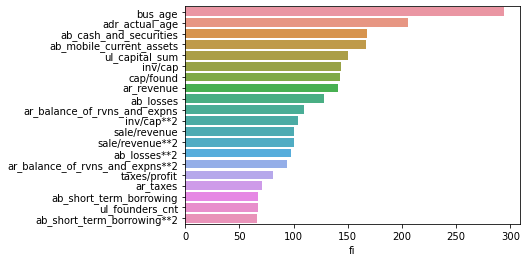

In [52]:
# топ 20 фичей
sns.barplot(feat_imp[~(feat_imp.cum_fi > 0.99)].fi[:20], feat_imp[~(feat_imp.cum_fi > 0.99)].index[:20])

In [53]:
feat_imp_lgbm_to_drop = feat_imp[feat_imp.cum_fi > 0.99].index.tolist()

In [54]:
len(feat_imp_lgbm_to_drop)

16

In [55]:
log_reg = LogisticRegression()
log_reg.fit(X, y_train)

LogisticRegression()

In [56]:
feat_imp_lr = pd.DataFrame(data={'weights': np.abs(log_reg.coef_)[0]}, \
                        index=X_train.drop(columns='ul_staff_range', axis=1)\
                        .columns.tolist()).sort_values(by='weights', ascending=False)

In [57]:
feat_imp_lr['cum_wieghts'] = np.cumsum(feat_imp_lr.weights) / sum(feat_imp_lr.weights)

In [58]:
feat_imp_lr_to_drop = feat_imp_lr[feat_imp_lr.cum_wieghts > 0.99].index.tolist()

In [59]:
len(feat_imp_lr_to_drop)

8

<AxesSubplot:xlabel='weights'>

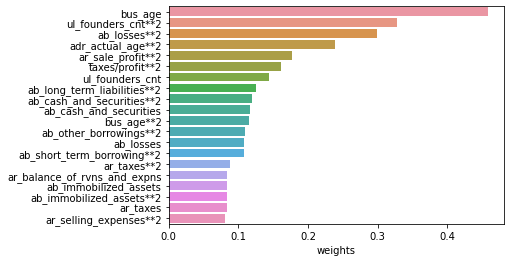

In [60]:
sns.barplot(feat_imp_lr.weights[:20], feat_imp_lr.index[:20])

In [62]:
# Общие менее важные признаки по двум моделям
set(feat_imp_lgbm_to_drop) & set(feat_imp_lr_to_drop)

{'ar_other_profit_and_losses', 'ul_capital_sum**2'}

# Modeling

In [63]:
rs = 69

In [64]:
X_train.shape

(32360, 49)

In [65]:
cat_feats = X_train.select_dtypes(include='object').columns
num_feats = X_train.select_dtypes(exclude='object').columns
X = X_train
y = y_train
X_tr, X_val, y_tr, y_val= train_test_split(X, y, test_size=0.2, random_state=rs)

In [66]:
# Метрики до отбора по feature_imp
res = pd.DataFrame(columns=['Name', 'auc'])

sc = StandardScaler()
transf = PowerTransformer(method='yeo-johnson')
numeric_transformer = Pipeline(steps=[('transf', transf), ('scaler', sc)])
cat_trans = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('numeric', numeric_transformer, num_feats),
        ('cat', cat_trans, cat_feats)
    ])

models = [LGBMClassifier(random_state=rs), CatBoostClassifier(random_state=rs, verbose=False), LogisticRegression()]
names = ['LightGBM', 'Catboost', 'LogReg']

for model, n  in zip(models, names):
    pipe = Pipeline(steps=[('prep', preprocessor), ('model', model)])
    kfold = StratifiedKFold(n_splits=4)
    score = cross_val_score(pipe, X_tr, y_tr, scoring='roc_auc', cv=kfold).mean()

    res = res.append({
        'Name' : n, 
        'auc' : round(score, 4), 
    }, ignore_index=True)
    del pipe

In [67]:
res

,Name,auc
0,LightGBM,0.7125
1,Catboost,0.7063
2,LogReg,0.6859


In [62]:
res

,Name,auc,auc_test,best_th
0,LightGBM,0.7107,0.7174,0.065296
1,Catboost,0.7079,0.7189,0.059256
2,LogReg,0.6865,0.6736,0.065444


Для линейных моделей, в частности для использования лог-регрессии, необходимо провести нормализацию данных. Выполним преобразование Йео-Джонсона, которое по сути преобразование box-cox, приближающее распределение к нормальному, но расширено на область отрицательных значений. Далее нормируем данные, вычтя среднее и дисперсию. В конце примением one-hot encoding, для категориальной фичи.  

Для оценки качества модели, как и говорилось ранее, будем использовать метрику roc-auc на стратифицированной кросс-валидации.
Для подбора порога в случае несбалансированной по классам выборки будем использовать геометрическое-среднее $\sqrt{tpr(1-fpr)}$

In [68]:
def fit_val_model(model, name, col_to_drop):
    cat_feats = X_train.drop(columns=col_to_drop).select_dtypes(include='object').columns
    num_feats = X_train.drop(columns=col_to_drop).select_dtypes(exclude='object').columns
    X = X_train.drop(columns=col_to_drop)
    y = y_train
    X_tr, X_val, y_tr, y_val= train_test_split(X, y, test_size=0.2, random_state=rs)
    
    res = pd.DataFrame(columns=['Name', 'auc', 'auc_test', 'best_th'])

    sc = StandardScaler()
    transf = PowerTransformer(method='yeo-johnson')
    numeric_transformer = Pipeline(steps=[('transf', transf), ('scaler', sc)])
    cat_trans = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[('numeric', numeric_transformer, num_feats),
            ('cat', cat_trans, cat_feats)
        ])

    models = [model]
    names = [name]

    for model, n  in zip(models, names):
        pipe = Pipeline(steps=[('prep', preprocessor), ('model', model)])
        kfold = StratifiedKFold(n_splits=4)
        score = cross_val_score(pipe, X_tr, y_tr, scoring='roc_auc', cv=kfold).mean()
        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict_proba(X_val)[:, 1]
        # Считаем метрику
        score_auc = roc_auc_score(y_val, y_pred)
        # Строим roc-auc кривую
        fpr, tpr, thresholds = roc_curve(y_val, y_pred)
        # Считаем гармоническое среднее и находим индекс, соотвествующий максимальному значению g-mean
        g_mean_idx = np.argmax(np.sqrt(tpr * (1-fpr)))
        # Выбираем порог
        bt = thresholds[g_mean_idx]  

        res = res.append({
            'Name' : n, 
            'auc' : round(score, 4), 
            'auc_test' : round(score_auc, 4),
            'best_th': bt
        }, ignore_index=True)
        del pipe
    return res

In [69]:
fit_val_model(LGBMClassifier(random_state=rs), 'LightGBM', feat_imp_lgbm_to_drop)

,Name,auc,auc_test,best_th
0,LightGBM,0.7107,0.7174,0.065296


In [70]:
fit_val_model(LogisticRegression(), 'Log_reg', feat_imp_lr_to_drop)

,Name,auc,auc_test,best_th
0,Log_reg,0.6864,0.6741,0.065693


# Предсказание и формирование файла с ответом

In [79]:
cat_feats = X_train.drop(columns=feat_imp_lgbm_to_drop).select_dtypes(include='object').columns
num_feats = X_train.drop(columns=feat_imp_lgbm_to_drop).select_dtypes(exclude='object').columns

sc = StandardScaler()
transf = PowerTransformer(method='yeo-johnson')
numeric_transformer = Pipeline(steps=[('transf', transf), ('scaler', sc)])
cat_trans = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('numeric', numeric_transformer, num_feats),
        ('cat', cat_trans, cat_feats)
    ])
X = preprocessor.fit_transform(X_train.drop(columns=feat_imp_lgbm_to_drop))
X_t = preprocessor.transform(X_test.drop(columns=feat_imp_lgbm_to_drop))

lgb = LGBMClassifier(random_state=rs)
lgb.fit(X, y_train)

lgb_pred = lgb.predict_proba(X_t)[:, 1]

In [80]:
X.shape[1]

35

In [81]:
answ_df = test_df[['record_id']]

In [82]:
answ_df['id'] = answ_df['record_id']

In [83]:
answ_df.drop('record_id',axis=1, inplace=True)

In [84]:
answ_df['predict'] = (lgb_pred>0.065296).astype(int)

In [85]:
answ_df.to_csv('PD-submit.csv',index=False, sep=';')

# Итого

Лучший скор выдала модель LGBM с добавлением полиномиальных фичей (- feats_to_drop + квадратичные - корреляция исходных) c accuracy = 0.67. Однако в данном случае признаков было ~80.
Цель - правильно разработанная модель, удовлетворяющая требованиям банковской системы. Чем меньше признаков, тем выше стабильность модели. При этом для банка важна интерпретируемость модели. В итоге в результате отбора признаков LGBM выдал accuracy = 0.64, однако число признаков значительно уменьшилось и стало равно 35. А так как модель не должна обладать излишней сложоностью, то в таком случае можно использовать логистическую регрессию.   